# **Project CNN: Alap Dhruva (400490512) - TASK A**

In [ ]:
# Import necessary libraries
from google.colab import files
from google.colab import drive
import zipfile
import os
import torch
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Zip file in Local Storage

In [ ]:
# # Upload and extract the dataset
# uploaded = files.upload()  # This will open a file upload dialog
# zip_file_path = '/content/Task1_data.zip'
# extract_path = '/content'
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("Files extracted to:", extract_path)


Zip file from google drive

In [ ]:
drive.mount('/content/drive')

# Define the path to the ZIP file
zip_path = '/content/drive/My Drive/Task1_data.zip'

# Define the extraction directory
extract_dir = '/content'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to {extract_dir}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files extracted to /content


Helper function for visualization

In [ ]:
# Define helper functions
def plot_sample(X, y, index, class_names):
    """Plots a single sample image with its corresponding class label."""
    plt.figure(figsize=(4, 4))
    plt.imshow(X[index])
    plt.xlabel(class_names[y[index]])
    plt.show()


# **CNN Architectures:**

In [ ]:
def cnn_architecture_1(input_shape, num_classes):
    """Baseline CNN with two convolutional layers and dropout."""
    inputs = layers.Input(shape=input_shape)  # Layer 1
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)  # Layer 2
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 3
    x = layers.Dropout(0.25)(x)  # Layer 4

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)  # Layer 5
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 6
    x = layers.Dropout(0.25)(x)  # Layer 7

    x = layers.Flatten()(x)  # Layer 8
    x = layers.Dense(128, activation='relu')(x)  # Layer 9
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Layer 10

    model = models.Model(inputs=inputs, outputs=outputs)
    print(f"Model 1 Total Parameters: {model.count_params()}")
    return model

def cnn_architecture_2(input_shape, num_classes):
    """CNN with smaller filters in the first layer, removing LeakyReLU."""
    inputs = layers.Input(shape=input_shape)  # Layer 1
    x = layers.Conv2D(48, (3, 3), activation='relu')(inputs)  # Layer 2 (reduced filters)
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 3
    x = layers.Dropout(0.3)(x)  # Layer 4

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)  # Layer 5
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 6
    x = layers.Dropout(0.3)(x)  # Layer 7

    x = layers.Flatten()(x)  # Layer 8
    x = layers.Dense(128, activation='relu')(x)  # Layer 9
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Layer 10

    model = models.Model(inputs=inputs, outputs=outputs)
    print(f"Model 2 Total Parameters: {model.count_params()}")
    return model

def cnn_architecture_3(input_shape, num_classes):
    """CNN with smaller second Conv2D layer and early dropout for better generalization."""
    inputs = layers.Input(shape=input_shape)  # Layer 1
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)  # Layer 2
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 3
    x = layers.Dropout(0.3)(x)  # Layer 4 (Early dropout)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)  # Layer 5 (Reduced filters)
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 6
    x = layers.Dropout(0.3)(x)  # Layer 7

    x = layers.Flatten()(x)  # Layer 8
    x = layers.Dense(128, activation='relu')(x)  # Layer 9
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Layer 10

    model = models.Model(inputs=inputs, outputs=outputs)
    print(f"Model 3 Total Parameters: {model.count_params()}")
    return model


# **CNN Class:**

In [ ]:
# Define the CNNModel class
class CNNModel:
    def __init__(self, train_path, test_path, label_mapping, class_names, input_shape, architecture_fn, epochs=20):
        self.train_path = train_path
        self.test_path = test_path
        self.label_mapping = label_mapping
        self.class_names = class_names
        self.input_shape = input_shape
        self.epochs = epochs
        self.is_built = False
        self.model = None
        self.architecture_fn = architecture_fn

    def load_data(self):
        # Load training and testing data
        train_data = torch.load(self.train_path)
        test_data = torch.load(self.test_path)

        # Print shape for debugging purposes
        print(train_data['data'].shape)

        # Preprocess Data
        X_train = np.transpose(train_data['data'].numpy(), (0, 2, 3, 1))  # Convert to (batch_size, height, width, channels)
        y_train = np.array([self.label_mapping[label] for label in train_data['labels']])  # Map labels

        X_test = np.transpose(test_data['data'].numpy(), (0, 2, 3, 1))
        y_test = np.array([self.label_mapping[label] for label in test_data['labels']])

        return X_train, y_train, X_test, y_test

    def build_model(self):
        # Build CNN model using the provided architecture function
        self.model = self.architecture_fn(self.input_shape, len(self.class_names))

        # Compile model
        self.model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

        self.model.summary()
        self.is_built = True

    def train(self, X_train, y_train):
        if self.model is None:
            raise ValueError("Model is not built yet.")

        # Train model
        self.model.fit(X_train.astype(np.float32), y_train, epochs=self.epochs)

    def evaluate(self, X_test, y_test):
        if self.model is None:
            raise ValueError("Model is not built yet.")

        # Evaluate model
        test_loss, test_accuracy = self.model.evaluate(X_test.astype(np.float32), y_test)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
        return test_loss, test_accuracy

    def classification_report(self, X_test, y_test):
        """ Generates classification report for the model """
        y_pred = np.argmax(self.model.predict(X_test.astype(np.float32)), axis=1)

        # Print the classification report
        print(f"Classification Report for {self.class_names[0]} Model:")
        print(classification_report(y_test, y_pred, target_names=self.class_names))

    def plot_confusion_matrix(self, X_test, y_test):
        """ Plots confusion matrix for the model """
        y_pred = np.argmax(self.model.predict(X_test.astype(np.float32)), axis=1)

        # Generate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot confusion matrix as heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title(f"Confusion Matrix for {self.class_names[0]} Model")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def save(self, model_name):
        if self.model is None:
            raise ValueError("Model is not built yet.")

        # Save the model
        self.model.save(model_name + ".h5")

    def get_model_weights(self):
        if self.model is None:
            raise ValueError("Model is not built yet.")
        # Return the model's weights as a list of numpy arrays
        return self.model.get_weights()


### **Defining the input shape and epochs**

In [ ]:
# Define input shape and epochs
input_shape = (32, 32, 3)
epochs = 20

# **Model 1:**

In [ ]:
# Model 1
train_path_1 = "/content/Task1_data/Model1/model1_train.pth"
test_path_1 = "/content/Task1_data/Model1/model1_test.pth"
label_mapping_1 = {
    0: 0,   # apple -> 0
    10: 1,  # bowl -> 1
    20: 2,  # chair -> 2
    30: 3,  # dolphin -> 3
    40: 4   # lamp -> 4
}
Classes1 = ['apple', 'bowl', 'chair', 'dolphin', 'lamp']

<ipython-input-9-f01da93fc2b9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data_1 = torch.load(test_path_1)


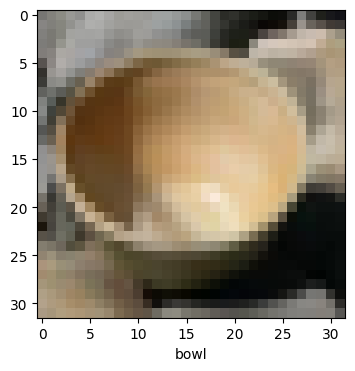

In [ ]:
# Plot a sample image from Model 1
test_data_1 = torch.load(test_path_1)
X_test_1 = np.transpose(test_data_1['data'].numpy(), (0, 2, 3, 1))
y_test_1 = np.array([label_mapping_1[label] for label in test_data_1['labels']])
plot_sample(X_test_1, y_test_1, 30, Classes1)

In [ ]:
# Train Model 1
model1 = CNNModel(train_path_1, test_path_1, label_mapping_1, Classes1, input_shape, cnn_architecture_1, epochs)

In [ ]:
X_train1, y_train1, X_test1, y_test1 = model1.load_data()

torch.Size([2500, 3, 32, 32])


<ipython-input-6-10b667bea619>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(self.train_path)
<ipython-input-6-10b667bea619>:17: FutureWarning: Y

In [ ]:
model1.build_model()

Model 1 Total Parameters: 628485


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 628,485 (2.40 MB)

 Trainable params: 628,485 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.train(X_train1, y_train1)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.4387 - loss: 1.3139
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6449 - loss: 0.9089
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7081 - loss: 0.7667
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7526 - loss: 0.6531
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7908 - loss: 0.5566
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8155 - loss: 0.5143
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8302 - loss: 0.4471
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8641 - loss: 0.3743
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8791 - loss: 0.3419
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9014 - loss: 0.2804
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8895 - loss: 0.2848
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8996 

In [ ]:
model1.evaluate(X_test1, y_test1)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8199 - loss: 0.6100
Test Accuracy: 81.80%


(0.60047847032547, 0.8180000185966492)

In [ ]:
model1.classification_report(X_test1, y_test1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Classification Report for apple Model:
              precision    recall  f1-score   support

       apple       0.83      0.91      0.87       100
        bowl       0.76      0.65      0.70       100
       chair       0.88      0.82      0.85       100
     dolphin       0.88      0.92      0.90       100
        lamp       0.73      0.79      0.76       100

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


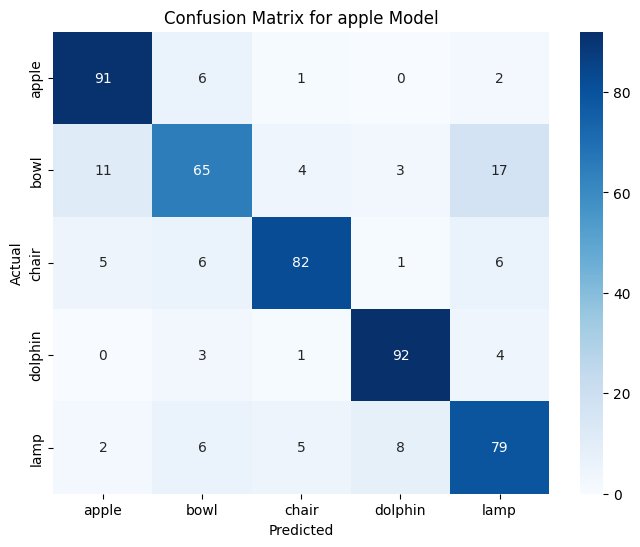

In [ ]:
model1.plot_confusion_matrix(X_test1, y_test1)

In [ ]:
model1.save("model1")

# **Model 2:**

In [ ]:
# Model 2
train_path_2 = "/content/Task1_data/Model2/model2_train.pth"
test_path_2 = "/content/Task1_data/Model2/model2_test.pth"
label_mapping_2 = {
    1: 0,   # aquarium_fish -> 0
    11: 1,  # boy -> 1
    21: 2,  # chimpanzee -> 2
    31: 3,  # elephant -> 3
    41: 4   # lawn_mower -> 4
}
Classes2 = ['aquarium_fish', 'boy', 'chimpanzee', 'elephant', 'lawn_mower']

<ipython-input-19-988c6b882bb0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data_2 = torch.load(test_path_2)


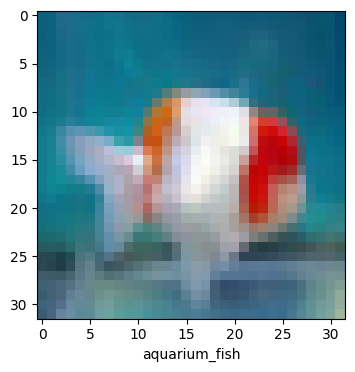

In [ ]:
# Plot a sample image from Model 2
test_data_2 = torch.load(test_path_2)
X_test_2 = np.transpose(test_data_2['data'].numpy(), (0, 2, 3, 1))
y_test_2 = np.array([label_mapping_2[label] for label in test_data_2['labels']])
plot_sample(X_test_2, y_test_2, 40, Classes2)

In [ ]:
# Train Model 2
model2 = CNNModel(train_path_2, test_path_2, label_mapping_2, Classes2, input_shape, cnn_architecture_2, epochs)

In [ ]:
X_train2, y_train2, X_test2, y_test2 = model2.load_data()

torch.Size([2500, 3, 32, 32])


<ipython-input-6-10b667bea619>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(self.train_path)
<ipython-input-6-10b667bea619>:17: FutureWarning: Y

In [ ]:
model2.build_model()

Model 2 Total Parameters: 647365


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 48)          │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 15, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 128)         │          55,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 647,365 (2.47 MB)

 Trainable params: 647,365 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.train(X_train2, y_train2)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.3267 - loss: 1.4646
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6140 - loss: 1.0117
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6982 - loss: 0.7989
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7655 - loss: 0.6820
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7854 - loss: 0.5783
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8145 - loss: 0.5139
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8136 - loss: 0.4801
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8479 - loss: 0.4204
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8449 - loss: 0.4339
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8829 - loss: 0.3422
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9064 - loss: 0.2747
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9093 - l

In [ ]:
model2.evaluate(X_test2, y_test2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8163 - loss: 0.5877
Test Accuracy: 83.60%


(0.5385655164718628, 0.8360000252723694)

In [ ]:
model2.classification_report(X_test2, y_test2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Classification Report for aquarium_fish Model:
               precision    recall  f1-score   support

aquarium_fish       0.90      0.89      0.89       100
          boy       0.84      0.81      0.82       100
   chimpanzee       0.84      0.80      0.82       100
     elephant       0.79      0.80      0.80       100
   lawn_mower       0.81      0.88      0.85       100

     accuracy                           0.84       500
    macro avg       0.84      0.84      0.84       500
 weighted avg       0.84      0.84      0.84       500



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


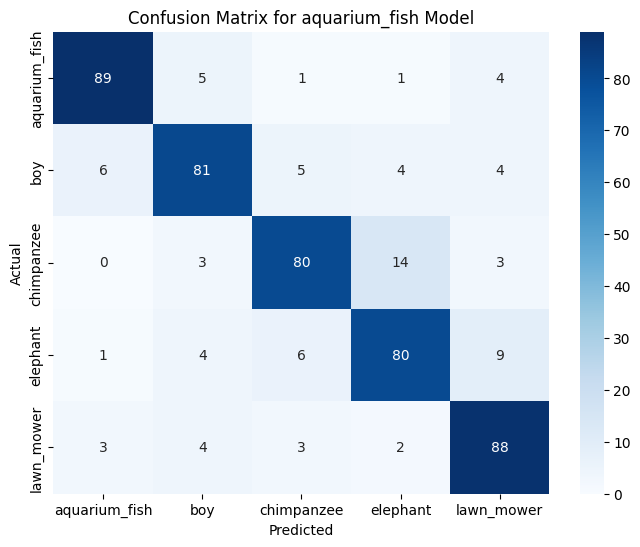

In [ ]:
model2.plot_confusion_matrix(X_test2, y_test2)

In [ ]:
model2.save("model2")

# **Model 3:**

In [ ]:
# Model 3
train_path_3 = "/content/Task1_data/Model3/model3_train.pth"
test_path_3 = "/content/Task1_data/Model3/model3_test.pth"
label_mapping_3 = {
    2: 0,   # baby -> 0
    12: 1,  # bridge -> 1
    22: 2,  # clock -> 2
    32: 3,  # flatfish -> 3
    42: 4   # leopard -> 4
}
Classes3 = ['baby', 'bridge', 'clock', 'flatfish', 'leopard']

<ipython-input-29-7e4b97a4c18b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data_3 = torch.load(test_path_3)


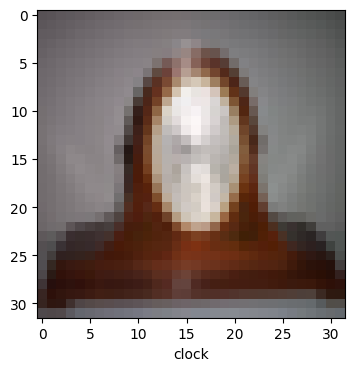

In [ ]:
# Plot a sample image from Model 3
test_data_3 = torch.load(test_path_3)
X_test_3 = np.transpose(test_data_3['data'].numpy(), (0, 2, 3, 1))
y_test_3 = np.array([label_mapping_3[label] for label in test_data_3['labels']])
plot_sample(X_test_3, y_test_3, 50, Classes3)

In [ ]:
# Train Model 3
model3 = CNNModel(train_path_3, test_path_3, label_mapping_3, Classes3, input_shape, cnn_architecture_3, epochs)

In [ ]:
X_train3, y_train3, X_test3, y_test3 = model3.load_data()

torch.Size([2500, 3, 32, 32])


<ipython-input-6-10b667bea619>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(self.train_path)
<ipython-input-6-10b667bea619>:17: FutureWarning: Y

In [ ]:
model3.build_model()

Model 3 Total Parameters: 666245


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 666,245 (2.54 MB)

 Trainable params: 666,245 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.train(X_train3, y_train3)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.2634 - loss: 1.5846
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4817 - loss: 1.3176
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5696 - loss: 1.1162
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6122 - loss: 1.0137
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6730 - loss: 0.9134
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6790 - loss: 0.8519
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7306 - loss: 0.7434
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7396 - loss: 0.7186
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7616 - loss: 0.6619
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7917 - loss: 0.5811
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8236 - loss: 0.4943
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8210 - l

In [ ]:
model3.evaluate(X_test3, y_test3)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7677 - loss: 0.7370
Test Accuracy: 77.00%


(0.7516987323760986, 0.7699999809265137)

In [ ]:
model3.classification_report(X_test3, y_test3)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Classification Report for baby Model:
              precision    recall  f1-score   support

        baby       0.71      0.78      0.74       100
      bridge       0.80      0.89      0.84       100
       clock       0.83      0.69      0.75       100
    flatfish       0.69      0.66      0.68       100
     leopard       0.82      0.83      0.83       100

    accuracy                           0.77       500
   macro avg       0.77      0.77      0.77       500
weighted avg       0.77      0.77      0.77       500



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


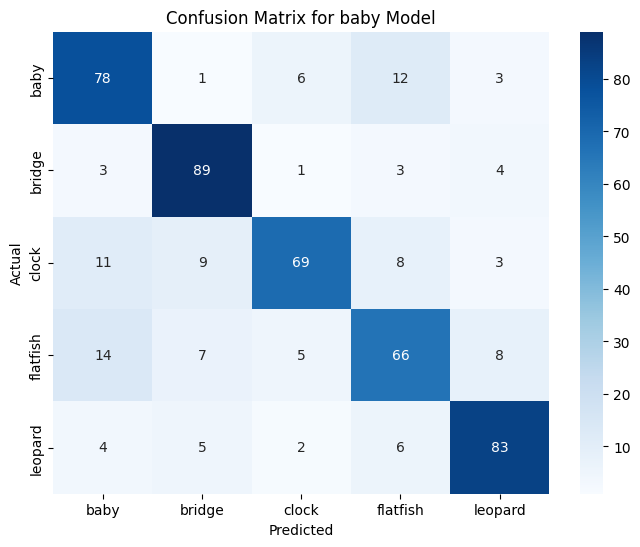

In [ ]:
model3.plot_confusion_matrix(X_test3, y_test3)

In [ ]:
model3.save("model3")

print("All models trained and saved successfully!")

All models trained and saved successfully!


Checking input shape:

In [ ]:
input_layer1 = model1.model.input
print(input_layer1)

<KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=False, name=keras_tensor>


In [ ]:
input_layer2 = model2.model.input
print(input_layer2)

<KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=False, name=keras_tensor_10>


In [ ]:
input_layer3 = model3.model.input
print(input_layer3)

<KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=False, name=keras_tensor_30>


# **Feature Level Fusion**

### **For Model 1, 2 and 3:**

In [ ]:
from keras import backend as K
import numpy as np

# Function to extract features from the penultimate layer
def extract_features(cnn_model, X):
    # Ensure the model is built by passing a dummy input through the call method

    feature_extractor = Model(inputs=cnn_model.model.input, outputs=cnn_model.model.layers[-3].output)
    return feature_extractor.predict(X.astype(np.float32))


# Extract features for training data
features_train1 = extract_features(model1, X_train1)
features_train2 = extract_features(model2, X_train2)
features_train3 = extract_features(model3, X_train3)

# Extract features for testing data
features_test1 = extract_features(model1, X_test1)
features_test2 = extract_features(model2, X_test2)
features_test3 = extract_features(model3, X_test3)


print(type(features_train1))
print(features_train1.shape)
print(features_train2.shape)
print(features_test1.shape)
print(features_test2.shape)
print(features_test3.shape)

# Feature-level fusion: Concatenation
fused_train_features = np.concatenate((features_train1, features_train2,features_train3), axis=0)
fused_test_features = np.concatenate((features_test1, features_test2,features_test3), axis=0)

print("fused_train_features",len(features_train1),len(features_train2),len(features_train3),"==",len(fused_train_features))
print("fused_test_features",len(features_test1),len(features_test2),len(features_test3),"==",len(fused_test_features))
# print("fuesed_test_feature")

# Define labels for fused model

y_train_fused = np.concatenate((y_train1, y_train2,y_train3), axis=0)
y_test_fused = np.concatenate((y_test1, y_test2,y_test3), axis=0)

# y_train_fused = y_train_fused[:2500]
# y_test_fused = y_test_fused[:500]

print("y_train_fused",len(y_train1),len(y_train2),len(y_train3),"==",len(y_train_fused))
print("y_test_fused",len(y_test1),len(y_test2),len(y_test3),"==",len(y_test_fused))

# Convert labels to categorical
num_classes = len(Classes1) + len(Classes2) + len(Classes3)

combined_classes_list = Classes1 + Classes2 + Classes3
print(combined_classes_list)
fused_train_features.shape

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
<class 'numpy.ndarray'>
(2500, 4608)
(2500, 4608)
(500, 4608)
(500, 4608)
(500, 4608)
fused_train_features 2500 2500 2500 == 7500
fused_test_features 500 500 500 == 1500
y_train_fused 2500 2500 2500 == 7500
y_test_fused 500 500 500 == 1500
['apple', 'bowl', 'chair', 'dolphin', 'lamp', 'aquarium_fish', 'boy', 'chimpanzee', 'elephant', 'lawn_mower', 'baby', 'bridge', 'clock', 'flatfish', 'leopard']


(7500, 4608)

In [ ]:
# Build classifier for fused features
input_layer = Input(shape=(fused_train_features.shape[1],))

dense1 = Dense(64, activation='relu')(input_layer)
dense2 = Dense(32, activation='relu')(dense1)
dense3 = layers.Dropout(0.5)(dense2)
dense4 = Dense(32, activation='relu')(dense3)
dense5 = Dense(16, activation='relu')(dense4)
dense6 = layers.Dropout(0.5)(dense5)
output_layer = Dense(num_classes, activation='softmax')(dense6)

fusion_model = Model(inputs=input_layer, outputs=output_layer)

# Compile fusion model
fusion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fusion_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │         294,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 15)                  │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,895 (1.14 MB)

 Trainable params: 298,895 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train fusion model
fusion_model.fit(fused_train_features, y_train_fused, epochs=10, validation_data=(fused_test_features, y_test_fused))

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2233 - loss: 2.2781 - val_accuracy: 0.6107 - val_loss: 1.1742
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4885 - loss: 1.3766 - val_accuracy: 0.6953 - val_loss: 0.9343
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6211 - loss: 1.0664 - val_accuracy: 0.7540 - val_loss: 0.7781
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6972 - loss: 0.8690 - val_accuracy: 0.7647 - val_loss: 0.7112
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7380 - loss: 0.7626 - val_accuracy: 0.7820 - val_loss: 0.7081
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7863 - loss: 0.6657 - val_accuracy: 0.7900 - val_loss: 0.7063
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7998 - loss: 0.5912 - val_accuracy: 0.7813 - val_loss: 0.8035
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8201 - loss: 0.5406 - val_accuracy: 0

In [ ]:
# Evaluate fusion model
fusion_model.evaluate(fused_test_features, y_test_fused)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8124 - loss: 0.7392


[0.8277817368507385, 0.7853333353996277]

In [ ]:
# Save the fused model
fusion_model.save("fusion_model.h5")